# Positional Embeddings in Transformer Architectures

Transformers have become a pivotal technology in the realm of machine learning, especially with the advent of Vision Transformers (ViTs). Their ability to process data in a highly parallel and efficient manner has led to groundbreaking advancements. However, transformers do not inherently recognize the order or position of the input data. This limitation is counteracted by the use of positional embeddings.

## What are Positional Embeddings?

Positional embeddings are additional vectors that are added to the input embeddings in a transformer model. These vectors carry information about the position or order of each element in the input sequence. This concept is crucial because the transformer's self-attention mechanism treats each input independently and lacks the means to consider the sequence or spatial arrangement of the inputs.

### Why are Positional Embeddings Essential?

Transformers process inputs as sets of elements. Positional embeddings enable the model to differentiate between elements that are similar in nature but vary in their position within the sequence. This is particularly important in tasks like language understanding or image processing where the order and position of elements carry significant meaning.

Unlike models like CNNs, transformers do not have a built-in mechanism to process data in a sequential manner. Positional embeddings provide this sequential context, allowing the model to understand the order and relationship between different parts of the input.

## Positional Embeddings in Masked Auto-encoders

In the context of Masked Auto-encoders (MAEs), positional embeddings play a vital role. MAEs are designed to reconstruct input data (like images) from partially observed inputs. Here, positional embeddings are crucial for several reasons:

1. **Handling Incomplete Data**: Positional embeddings provide context about which parts of the input are present and which are masked. This helps the model in making more informed predictions about the missing parts.

2. **Efficient Learning**: With the added positional context, MAEs can learn more efficiently, focusing on the spatial relationships within the data, leading to better generalization and performance.

In [1]:
import matplotlib.pyplot as plt

def plot_pos_embed(pos_embed, xlabel='Features Dim', ylabel='Patches \n Dim'):
    fig = plt.figure(figsize=(7,30))
    img = plt.imshow(pos_embed, vmin=-1, vmax=1)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.tick_params(labelsize=8)

    '''
    fig.subplots_adjust(right=0.8, hspace=0.5)
    cbar_ax = fig.add_axes([0.81, 0.48, 0.02, 0.03])
    cbar = plt.colorbar(img, cbar_ax)
    cbar.set_label('Value', size=15)
    '''
    plt.tight_layout()
    plt.show()

# MAE Positional Embedding Method: 2D Sine-Cosine Embedding

In the realm of Masked Auto-encoders (MAEs), positional embedding plays a pivotal role in enabling the model to understand the spatial context of the input. The existing method for positional embedding in MAEs typically uses a 2D sine-cosine approach. Let's delve into how this method functions and its implications.

## The 2D Sine-Cosine Positional Embedding

### Conceptual Overview

The 2D sine-cosine positional embedding is a method that encodes the position of each patch of an image in a two-dimensional grid. This method utilizes trigonometric functions (sine and cosine) to create a unique positional embedding for each patch.

### Technical Details

1. **Grid Creation**: The method starts by creating a two-dimensional grid corresponding to the height and width of the image patches. This grid represents the positions of each patch in the image.

2. **Sine-Cosine Encoding**: For each position on the grid, the embedding is generated using a combination of sine and cosine functions. This encoding depends on the dimensionality of the embedding space (`embed_dim`).

3. **Embedding Dimensions**: The embedding dimensions are evenly split to encode the horizontal and vertical positions separately. Each dimension is encoded using sine for one half and cosine for the other half.

4. **Concatenation of Embeddings**: The final embedding for each position is obtained by concatenating the sine and cosine embeddings for both the horizontal and vertical components.

### Implementation Aspects

- **Embedding for Each Patch**: The positional embedding is calculated for each patch in the image. If the image is divided into `N` patches, there will be `N` unique positional embeddings.
- **Class Token Embedding**: Optionally, a class token (`cls_token`) can be added. This is a special token used in transformers, often representing the entire image or sequence.
- **Adaptability to Image and Patch Size**: The method is adaptable to different image and patch sizes. The grid is generated based on the number of patches, which depends on the image size and patch size.

torch.Size([1, 65, 768])


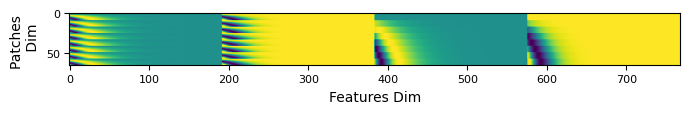

In [2]:
import numpy as np
import torch

# 2D sine-cosine position embedding
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

# Height and width of input images
img_size = 64
# Height and width of image patches
patch_size = 8
# Embedding dimension of encoder for each patch
embed_dim = 768

# Number of patches in each image
num_patches = int((img_size/patch_size)**2)

# Initialize pos_embed by sin-cos embedding
pos_embed = get_2d_sincos_pos_embed(embed_dim, int(num_patches**.5), cls_token=True)
pos_embed = torch.from_numpy(pos_embed).float().unsqueeze(0)

print(pos_embed.shape)
plot_pos_embed(pos_embed[0].data.numpy())

## Celestial Positional Embedding

The method shown above uses a *fixed* positional embedding for each patch in an image. This tells the transformer where each patch came from within the overall image.

For the purposes training an MAE on cosmological images and utilizing the model for downstream tasks, it will be useful to provide the encoder with information regarding where in **the sky** each patch comes from.

Additionally, since the resolution of the images depends on the position in the sky and the survey the image came from, the positional embedding should encode the resolution information as well; this will tell the model how far apart the patches in an image are from each other.

Therefore, we have a few objectives we want to achieve if we are going to create a new positional embedding method:

1. **RA and Dec Dependent Embeddings**: The new method aims to create positional embeddings based on the specific Right Ascension (RA) and Declination (Dec) of each image patch. RA and Dec are celestial coordinates used in astronomy to specify the direction of a point in the sky. RA ranges from 0 to 360 degrees, and Dec ranges from -90 to +90 degrees.

2. **Interpolation for Different Resolutions**: The method should be adaptable to images of different resolutions. This implies that the positional embeddings should be capable of being interpolated or scaled according to the resolution of the image, ensuring consistency across different image sizes.

3. **Real-Time Function Call**: The positional embedding function should be designed to be callable in real-time. This means it should efficiently compute the RA and Dec dependent embeddings for each patch when an image is being processed.

### Proposed Approach:

To achieve these objectives, we can design a function that maps RA and Dec coordinates to a high-dimensional space (similar to how 2D coordinates were mapped in the sine-cosine embedding). This function should consider the following:

- **Normalization of Coordinates**: RA and Dec values should be normalized based on their respective ranges to ensure uniformity in the embedding space.
- **Trigonometric Encoding**: Similar to the sine-cosine method, we can use trigonometric functions to encode RA and Dec values. This approach effectively captures the cyclical nature of these coordinates.
- **Embedding Concatenation**: For each image patch, the RA and Dec embeddings can be concatenated to form a complete positional embedding.

By designing a positional embedding function with these considerations, we can significantly enhance the MAE's ability to understand the spatial context of image patches based on their celestial coordinates. 

In [3]:
import torch
import numpy as np

def celestial_pos_embedding_batch(central_ras, central_decs, ra_res, dec_res, img_size, num_patches, embed_dim,
                                  ra_range=[0, 360], dec_range=[-90, 90]):
    """
    Generate celestial positional embeddings for a batch of images.

    Args:
    central_ras (torch.Tensor): Tensor of central Right Ascensions for the batch, shape: [batch_size].
    central_decs (torch.Tensor): Tensor of central Declinations for the batch, shape: [batch_size].
    ra_res (torch.Tensor): Tensor of RA resolutions for the batch, shape: [batch_size].
    dec_res (torch.Tensor): Tensor of Dec resolutions for the batch, shape: [batch_size].
    img_size (int): Size of the images in pixels (assumed to be square).
    num_patches (int): Total number of patches in each image.
    embed_dim (int): Dimension of the embedding vector for each patch.
    ra_range (list): The range of Right Ascension values, default is [0, 360].
    dec_range (list): The range of Declination values, default is [-90, 90].

    Returns:
    torch.Tensor: Tensor of shape [batch_size, num_patches, embed_dim] containing positional embeddings.
    """

    batch_size = central_ras.size(0)
    # Normalize RA and Dec values to [0, 1] range for the whole batch
    norm_ras = (central_ras - ra_range[0]) / (ra_range[1] - ra_range[0])
    norm_decs = (central_decs - dec_range[0]) / (dec_range[1] - dec_range[0])

    # Calculate the size of each patch and the number of patches along one dimension
    patch_size = img_size / np.sqrt(num_patches)
    num_patches_side = int(np.sqrt(num_patches))

    # Calculate the offsets to center RA and Dec in the middle of each image
    center_offset_ra = (patch_size * ra_res) / 2
    center_offset_dec = (patch_size * dec_res) / 2

    # Create a linear space for trigonometric encoding, to be used for both RA and Dec
    sin_cos_range = torch.linspace(0, 2 * np.pi, embed_dim // 4)

    # Compute the column and row indices for each patch
    cols, rows = torch.meshgrid(torch.arange(num_patches_side), torch.arange(num_patches_side), indexing='ij')
    cols = cols.flatten()
    rows = rows.flatten()

    # Initialize the embeddings tensor
    pos_embeddings_batch = torch.zeros((batch_size, num_patches, embed_dim), device=central_ras.device)

    # Process each image in the batch
    for i in range(batch_size):
        # Adjust for central RA/Dec and calculate offsets
        ra_offsets = ((cols - num_patches_side / 2) * ra_res[i] * patch_size + center_offset_ra[i]) / (ra_range[1] - ra_range[0])
        dec_offsets = ((rows - num_patches_side / 2) * dec_res[i] * patch_size + center_offset_dec[i]) / (dec_range[1] - dec_range[0])

        # Normalize offsets and wrap within [0, 1]
        patch_ras = (norm_ras[i] + ra_offsets) % 1
        patch_decs = (norm_decs[i] + dec_offsets) % 1

        # Create trigonometric embeddings for RA and Dec
        ra_embeddings = torch.cat([torch.sin(sin_cos_range * patch_ras[:, None]),
                                   torch.cos(sin_cos_range * patch_ras[:, None])], dim=1)
        dec_embeddings = torch.cat([torch.sin(sin_cos_range * patch_decs[:, None]),
                                    torch.cos(sin_cos_range * patch_decs[:, None])], dim=1)

        # Concatenate the RA and Dec embeddings for each patch
        pos_embeddings_batch[i] = torch.cat([ra_embeddings, dec_embeddings], dim=1)

    return pos_embeddings_batch

To illustrate what is going on, let's first create a positional embedding for an image that takes up the entire sky:

torch.Size([1, 64, 768])


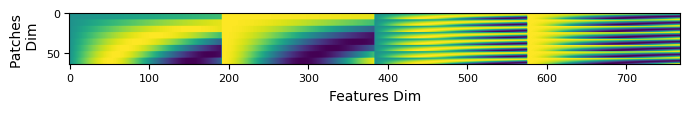

In [4]:
# Example usage
img_size = 64     # Image height and width in pixels
central_ras = torch.tensor([180])  # Degrees
central_decs = torch.tensor([0])   # Degrees
ra_res = torch.tensor([360/img_size])    # RA resolutions in degrees per pixel for each image in the batch
dec_res = torch.tensor([180/img_size])    # Dec resolutions in degrees per pixel for each image in the batch
num_patches = 64  # Number of patches
embed_dim = 768   # Embedding dimension

# Get positional embeddings for the batch
pos_embeddings_batch = celestial_pos_embedding_batch(central_ras, central_decs, ra_res, dec_res, img_size, num_patches, embed_dim)
print(pos_embeddings_batch.shape)  # Should be [batch_size, num_patches, embed_dim]
plot_pos_embed(pos_embeddings_batch[0].data.numpy())

Now something that is moving towards actual images:

torch.Size([2, 64, 768])
Positional embedding for an image at RA=60, Dec=-50


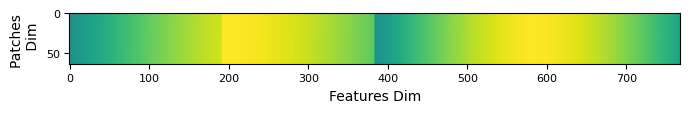

Positional embedding for an image at RA=230, Dec=100


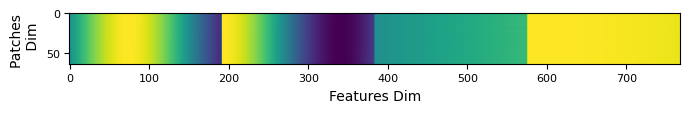

In [5]:
# Example usage
img_size = 64     # Image size in pixels
central_ras = torch.tensor([60,230])  # Example batch of central RAs
central_decs = torch.tensor([-50,100])    # Example batch of central Decs
ra_res = torch.tensor([0.01, 0.01])     # RA resolution in degrees per pixel
dec_res = torch.tensor([0.01, 0.01])    # Dec resolution in degrees per pixel
num_patches = 64  # Number of patches
embed_dim = 768   # Embedding dimension

# Get positional embeddings for the batch
pos_embeddings_batch = celestial_pos_embedding_batch(central_ras, central_decs, ra_res, dec_res, img_size, num_patches, embed_dim)
print(pos_embeddings_batch.shape)  # Should be [batch_size, num_patches, embed_dim]
for pos_embed, ra, dec in zip(pos_embeddings_batch, central_ras, central_decs):
    print(f'Positional embedding for an image at RA={ra}, Dec={dec}')
    plot_pos_embed(pos_embed.data.numpy())

It remains to be seen if this will provide enough variation across the individual patches in an image. To provide more variation, we could limit the range of RA and Dec values depending on the survey(s) we are considering, but when the range is much larger than the resolution, the variation in the positional embeddings is very low.

For example, the Deep/Ultra-Deep images in HSC span the ranges RA:(33$^{\circ}$ to 355$^{\circ}$) and Dec: (-7$^{\circ}$ to 57$^{\circ}$).

After investigating the data, I wrote a simple function to roughly determine the resolution at a given RA and Dec:

In [6]:
def evaluate_polynomial(coefficients, x):
    """ Evaluate a polynomial with given coefficients at x (similar to np.poly1d).
    
    Args:
    coefficients (Tensor): A tensor of coefficients, [a_n, ..., a_1, a_0]
    x (Tensor): Points at which to evaluate, can be a scalar or a tensor
    
    Returns:
    Tensor: The evaluated polynomial
    """
    degree = len(coefficients) - 1
    y = torch.zeros_like(x)
    for i, coeff in enumerate(coefficients):
        y += coeff * x ** (degree - i)
    return y

def hsc_dud_res(ra, dec):
    '''Return the resolution of the images.'''
    # The Dec resolution is pretty constant in the frames that I looked at
    dec_res = 4.7e-05

    # The RA resolution was dependent on the Dec.
    # In the Dec range [-10,60], this cubic function returns a pretty good estimate
    coefficients = torch.tensor([-2.4e-10, 1.02e-09, 2.869e-08, -4.672178e-05])
    ra_res = evaluate_polynomial(coefficients, dec)
    return ra_res, torch.ones_like(ra_res)*dec_res

Let's create embeddings for locations in the HSC Deep/Utra-Deep survey.

Creating positional embeddings for the ranges RA:[33, 355], Dec:[-7, 57]
Positional embedding for an image at RA=15.0, Dec=2.0
	the resolution of the image is RA=-4.67e-05, Dec=4.70e-05


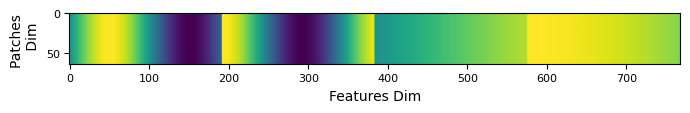

Positional embedding for an image at RA=34.5, Dec=-5.0
	the resolution of the image is RA=-4.68e-05, Dec=4.70e-05


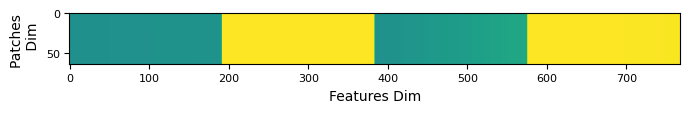

In [7]:
# Define range of RA and Dec
ra_range = [33,355]
dec_range = [-7,57]

# Some RA and Dec values in the HSC D/UD data
central_ras = torch.tensor([15,34.5])
central_decs = torch.tensor([2.,-5.])
# Determine the resolution at these spots
ra_res, dec_res = hsc_dud_res(central_ras, central_decs)

img_size = 64     # Image size in pixels
num_patches = 64  # Number of patches
embed_dim = 768   # Embedding dimension


print(f'Creating positional embeddings for the ranges RA:{ra_range}, Dec:{dec_range}')
# Get positional embeddings for the batch
pos_embeddings_batch = celestial_pos_embedding_batch(central_ras, central_decs, ra_res, dec_res, img_size, num_patches, embed_dim, 
                                                     ra_range=ra_range, dec_range=dec_range)

for pos_embed, ra, dec, ra_r, dec_r in zip(pos_embeddings_batch, central_ras, central_decs, ra_res, dec_res):
    print(f'Positional embedding for an image at RA={ra}, Dec={dec}')
    print(f'\tthe resolution of the image is RA={ra_r:0.2e}, Dec={dec_r:0.2e}')
    plot_pos_embed(pos_embed.data.numpy())

## Encoding the location in the image-space

From the previous experiment, the positional embedding approach would successfully encode where each patch is in the sky. However, it is very unlikely that this would provide the network with sufficient information to discern the sequential ordering of each patch in a given image.

Alernatively, we could maintain the original positional embedding method and add a channel to our images that encodes the celestial positioning information.

To create a function that encodes the Right Ascension (RA) and Declination (Dec) information for each pixel in an image, we will follow a similar approach to the previous function but adapt it for pixel-level encoding. The function will generate an image channel of size (`img_size` x `img_size`) for each image in the batch, where each pixel's value encodes the RA and Dec information using sine and cosine functions.

In [8]:
import torch
import numpy as np

def celestial_pixel_embedding(central_ras, central_decs, ra_res, dec_res, img_size, ra_range=[0, 360], dec_range=[-90, 90]):
    """
    Generate celestial pixel embeddings for a batch of images.

    Args:
    central_ras (torch.Tensor): Tensor of central Right Ascensions for the batch, shape: [batch_size].
    central_decs (torch.Tensor): Tensor of central Declinations for the batch, shape: [batch_size].
    ra_res (torch.Tensor): Tensor of RA resolutions for the batch, shape: [batch_size].
    dec_res (torch.Tensor): Tensor of Dec resolutions for the batch, shape: [batch_size].
    img_size (int): Size of the images in pixels (assumed to be square).
    ra_range (list): The range of Right Ascension values, default is [0, 360].
    dec_range (list): The range of Declination values, default is [-90, 90].

    Returns:
    torch.Tensor: A tensor of shape [batch_size, img_size, img_size] containing celestial pixel embeddings.
    """

    batch_size = central_ras.size(0)
    # Normalize RA and Dec values to [0, 1] range for the whole batch
    norm_ras = (central_ras - ra_range[0]) / (ra_range[1] - ra_range[0])
    norm_decs = (central_decs - dec_range[0]) / (dec_range[1] - dec_range[0])

    # Calculate the center offset for RA and Dec
    center_offset = img_size / 2 - 0.5

    # Initialize the embeddings tensor
    pixel_embeddings = torch.zeros((batch_size, img_size, img_size), device=central_ras.device)

    # Compute the column and row indices for each pixel
    cols, rows = torch.meshgrid(torch.arange(img_size), torch.arange(img_size), indexing='xy')

    # Process each image in the batch
    for i in range(batch_size):
        # Adjust for central RA/Dec and calculate offsets
        ra_offsets = ((cols - center_offset) * ra_res[i]) / (ra_range[1] - ra_range[0])
        dec_offsets = ((rows - center_offset) * dec_res[i]) / (dec_range[1] - dec_range[0])

        # Normalize offsets and wrap within [0, 1]
        patch_ras = (norm_ras[i] + ra_offsets) % 1
        patch_decs = (norm_decs[i] + dec_offsets) % 1

        # Combine RA and Dec information using sine and cosine functions
        ra_embedding = torch.sin(patch_ras * 2 * np.pi)
        dec_embedding = torch.sin(patch_decs * np.pi)

        # Combine the embeddings to form a single channel
        pixel_embeddings[i] = ra_embedding + dec_embedding

    return pixel_embeddings

Again, let's start by visualizing what this positional channel looks like across the entire sky

torch.Size([1, 64, 64])


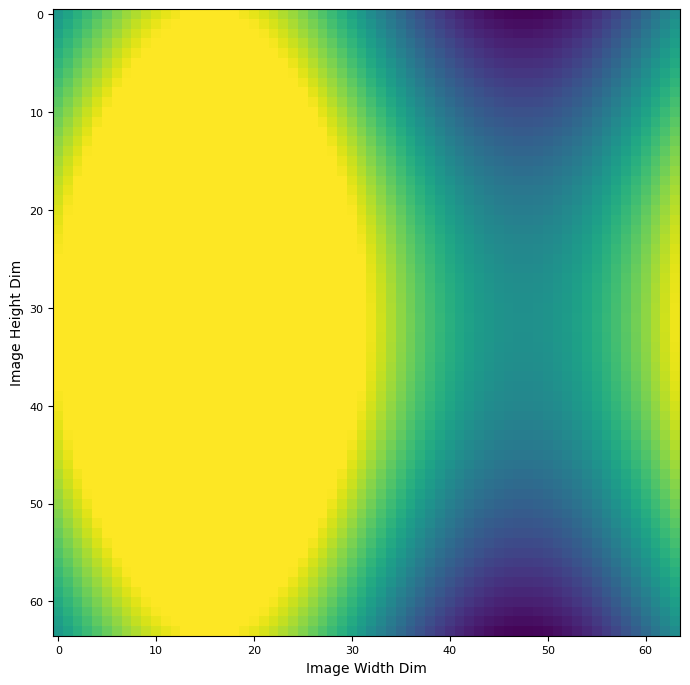

In [9]:
img_size = 64
central_ras = torch.tensor([180])
central_decs = torch.tensor([0]) 
ra_res = torch.tensor([360/img_size]) 
dec_res = torch.tensor([180/img_size])

# Get celestial pixel embeddings for the batch
pixel_embeddings = celestial_pixel_embedding(central_ras, central_decs, ra_res, dec_res, img_size)
print(pixel_embeddings.shape)  # Should be [batch_size, num_patches, embed_dim]
plot_pos_embed(pixel_embeddings[0].data.numpy(), xlabel='Image Width Dim', ylabel='Image Height Dim')

and now for our two locations in the HSC D/UD data:

Creating positional channel for the ranges RA:[33, 355], Dec:[-7, 57]
Positional embedding for an image at RA=15.0, Dec=2.0
	the resolution of the image is RA=-4.67e-05, Dec=4.70e-05


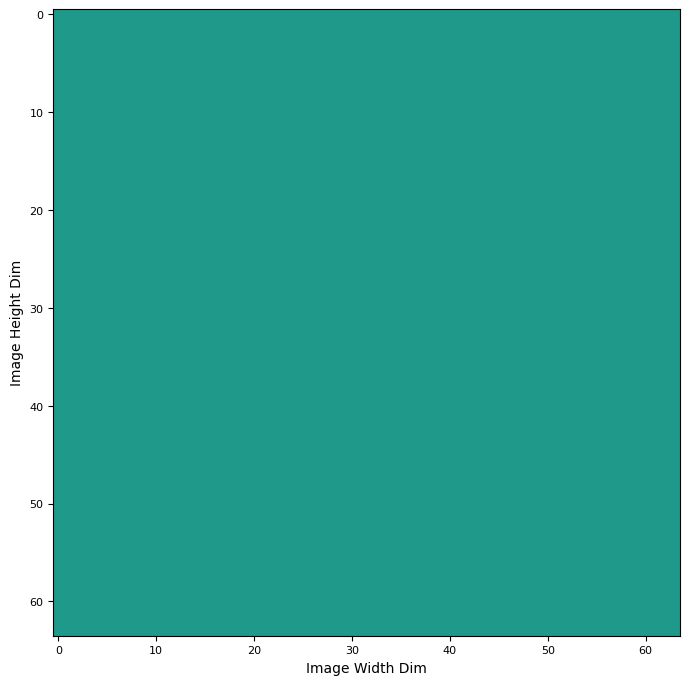

Positional embedding for an image at RA=34.5, Dec=-5.0
	the resolution of the image is RA=-4.68e-05, Dec=4.70e-05


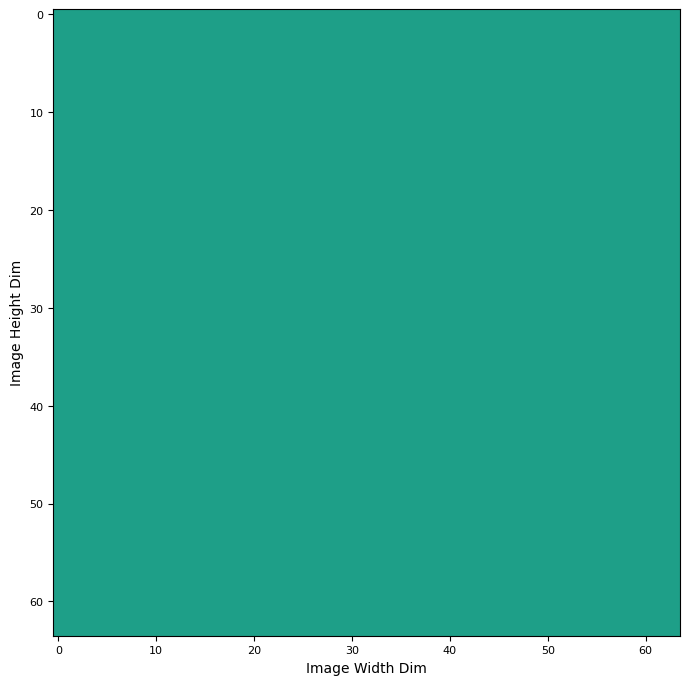

In [13]:
# Define range of RA and Dec
ra_range = [33,355]
dec_range = [-7,57]

# Some RA and Dec values in the HSC D/UD data
central_ras = torch.tensor([15,34.5])
central_decs = torch.tensor([2.,-5.])
# Determine the resolution at these spots
ra_res, dec_res = hsc_dud_res(central_ras, central_decs)

img_size = 64     # Image size in pixels

print(f'Creating positional channel for the ranges RA:{ra_range}, Dec:{dec_range}')
# Get celestial pixel for the batch
pixel_embeddings = celestial_pixel_embedding(central_ras, central_decs, ra_res, dec_res, img_size, 
                                                     ra_range=ra_range, dec_range=dec_range)

for pos_embed, ra, dec, ra_r, dec_r in zip(pixel_embeddings, central_ras, central_decs, ra_res, dec_res):
    print(f'Positional embedding for an image at RA={ra}, Dec={dec}')
    print(f'\tthe resolution of the image is RA={ra_r:0.2e}, Dec={dec_r:0.2e}')
    plot_pos_embed(pos_embed.data.numpy(), xlabel='Image Width Dim', ylabel='Image Height Dim')

The images don't really show the changes well:

In [12]:
pixel_embeddings[0], pixel_embeddings[1]

(tensor([[0.0835, 0.0835, 0.0835,  ..., 0.0834, 0.0834, 0.0834],
         [0.0835, 0.0835, 0.0835,  ..., 0.0834, 0.0834, 0.0834],
         [0.0835, 0.0835, 0.0835,  ..., 0.0834, 0.0834, 0.0834],
         ...,
         [0.0836, 0.0836, 0.0836,  ..., 0.0835, 0.0835, 0.0835],
         [0.0836, 0.0836, 0.0836,  ..., 0.0835, 0.0835, 0.0835],
         [0.0836, 0.0836, 0.0836,  ..., 0.0835, 0.0835, 0.0835]]),
 tensor([[0.1272, 0.1272, 0.1272,  ..., 0.1272, 0.1272, 0.1272],
         [0.1272, 0.1272, 0.1272,  ..., 0.1272, 0.1272, 0.1272],
         [0.1272, 0.1272, 0.1272,  ..., 0.1272, 0.1272, 0.1272],
         ...,
         [0.1274, 0.1274, 0.1274,  ..., 0.1273, 0.1273, 0.1273],
         [0.1274, 0.1274, 0.1274,  ..., 0.1273, 0.1273, 0.1273],
         [0.1274, 0.1274, 0.1274,  ..., 0.1273, 0.1273, 0.1273]]))